## Intro

A couple of months ago, I found an abandoned world map in my new office space, and put it on the wall.

![World Map](imgs/worldmap.jpg)

And one day I stumbled upon an interesting idea when looking at the atlas. The names of the cities are similar to each other when they are geographically close to each other. For example, Stratford, Wilford, and Bradford are in England, Europe. Pyeongchang, Pyongyang in the Korean peninsula, Asia. 
![pyeongchang](imgs/pyeongchang.png)

On hearing Pyeongchang and Pyongyang, one could think that they are in the same area without any difficulties. Like this poor pilot (http://www.telegraph.co.uk/news/2017/04/02/airport-mix-up-sees-winter-olympics-delegation-land-pyongyang/).

![poor pilot](imgs/poor_pilot.png)

If we can tell where the cities are just by hearing their names, can we train a machine to do that too?

<br>

## Dataset

To train a complicated Deep Learning model, one would need a lot of data. The more, the merrier! 

Wikipedia provides the list of cities with 100,000+ residents for free, but it wasn't enough. I found a freely available source that contains as many as 10,000 cities. As it didn't have the continent label I needed, I preprocessed it a little bit to get the dataset I wanted.

You can download it from my GitHub repo. It looks like the following table, and it has 7,221 cities and thier corresponding country and continent information.

In [1]:
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [2]:
raw_df = pd.read_csv('city_continent.csv')
raw_df.head()

,city_ascii,country,continent
0,Qal eh-ye,Afghanistan,Asia
1,Chaghcharan,Afghanistan,Asia
2,Lashkar Gah,Afghanistan,Asia
3,Zaranj,Afghanistan,Asia
4,Tarin Kowt,Afghanistan,Asia


In [3]:
## number of data points
len(raw_df)

7221

## Approach

The goal is to find and optimize a function that maps the city names to their continents. It is a simple text-classification problem. I used PyTorch which I'd heard a lot about recently. 

Here's how I designed the process.  

### 1. Prepare Dataset
split the dataset into train, validation, and test set.

### 2. Define Vocabulary
build a vocabulary to encode text into vectors

### 3. Define LSTM model
uni/bidirectional, number of embeddings, number of hidden units, number of layers, dropout

### 4. Train 
run training

### 5. Evaluate
compare model performance on test set


## 1. Prepare Dataset
`sklearn`'s `train_test_split` really comes in handy when chopping the dataset nicely. I made a function named `prepare_dataset` to split the raw dataset into train, validation, and test set, and to save them in the target directory.

In [4]:
import os
from sklearn.model_selection import train_test_split

def prepare_dataset(path, target_dir):
    df = pd.read_csv(path)[['city_ascii', 'continent']]

    X_train, X_test, y_train, y_test = train_test_split(df.city_ascii, 
                                                        df.continent, 
                                                        test_size=0.1, 
                                                        random_state=42, 
                                                        stratify=df.continent)

    X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                        y_train, 
                                                        test_size=0.1, 
                                                        random_state=42, 
                                                        stratify=y_train)

    trainSet = pd.concat([X_train, y_train], axis=1)
    valSet = pd.concat([X_val, y_val], axis=1)
    testSet = pd.concat([X_test, y_test], axis=1)
    
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
    
    trainSet.to_csv(os.path.join(target_dir, '_train.csv'), index=None)
    valSet.to_csv(os.path.join(target_dir, '_val.csv'), index=None)
    testSet.to_csv(os.path.join(target_dir, '_test.csv'), index=None)

In [5]:
prepare_dataset('city_continent.csv', 'dataset')

## 2. Define Vocabulary

When building a text-based deep learning model, it's cumbersome to transform text into vectors. We would have to make a word or character set and make a dictionary that maps a word to an integer. And you would want to give space to `<unk>` in case the model stumbles upon an unseen character.

Luckily a group of kind-minded geniuses made a publicly available tool for it, and its name is `torchtext`<a href="https://github.com/pytorch/text">(GitHub)</a>. It is a fantastic tool that enables quick and easy vocab-construction. 

In [6]:
from torchtext import data

First, we need to define the text and label columns. `CITY` is a column that has city name text. Because it is a sequential data type, I give it `sequential=True`. Sequence processing is easily done just by passing the tokenizer function I defined below.

The column `CONTINENT` is a categorical data type, yet it is not a numerical datatype yet. So I pass `use_vocab=True` for it.

In [7]:
## City name tokenizer
## 'Seoul' -> ['S', 'e', 'o', 'u', 'l']
def tokenizer(text):
    return list(text)

tokenizer("Seoul")

['S', 'e', 'o', 'u', 'l']

In [8]:
CITY = data.Field(sequential=True, pad_first=True, tokenize=tokenizer)
CONTINENT = data.Field(sequential=False, use_vocab=True)

`data.TabularDataset.splits` is a super conveninent function that loads the preprocessed datasets I splited above. `CITY` and `CONTINENT` fields are passed into the function with the actual column name.

In [9]:
train, val, test = data.TabularDataset.splits(
    path='dataset', skip_header=True, train='_train.csv',
    validation='_val.csv', test='_test.csv', format='csv',
    fields=[('city_ascii', CITY), ('continent', CONTINENT)]
)

`some_field.build_vocab(dataset)` literally builds vocab. Before the construction, our data field doesn't have its vocab.

In [10]:
CITY.vocab

AttributeError: 'Field' object has no attribute 'vocab'

In [11]:
CITY.build_vocab(train, val, test)
CONTINENT.build_vocab(train, val, test)

And now it does. `field.vocab.stoi` maps characters to their integers, `field.vocab.itos` the other way round. 

In [12]:
CITY.vocab.stoi['A']

26

In [13]:
CITY.vocab.itos[26]

'A'

In [14]:
CONTINENT.vocab.freqs

Counter({'Africa': 1284,
         'Asia': 2334,
         'Europe': 847,
         'North America': 1418,
         'Oceania': 297,
         'South America': 1041})

Let's turn the loaded datasets into generators which are handy when training a neural network. `data.BucketIterator.splits` uses `sort_key` to group city names that are of similar lengths, which minimizes the number of paddings.

In [15]:
train_iter, val_iter, test_iter = data.BucketIterator.splits(
    (train, val, test), batch_sizes=(16, 16, 16), repeat=False,
    sort_key=lambda x: len(x.city_ascii), device=-1
)

Here's a vectorized city name and continent label a train iterator would deliver to the model.

In [16]:
sample = next(iter(train_iter))

In [17]:
list(sample.city_ascii[:, 0].data)

[28, 6, 25, 8, 10, 12, 6]

In [18]:
"".join([CITY.vocab.itos[i] for i in list(sample.city_ascii[:, 0].data)])

'Kipushi'

In [19]:
sample.continent[0].data


 3
[torch.LongTensor of size 1]

In [20]:
CONTINENT.vocab.itos[sample.continent[0].data.numpy()[0]]

'Africa'

## 3. Define LSTM Models
A lot of tutorials codes that I took a reference to use Class to define their own neural network in PyTorch. I found this approach a little bit confusing at first because I was quite happy with Keras sequential. But it kinda has grown on me, and I like how I can generate multiple models just by tweaking parameters that I pass in.

`ParameterGrid` from `sklearn` is a handy tool for building a parameter grid. Here I experimented with the number of LSTM layers, dropout in LSTM, dropout in the fully connected layer at the end, and whether the LSTM is bidirectional. 

In [21]:
from sklearn.model_selection import ParameterGrid

grid = {'BATCH_SIZE': [16], 'EMBEDDING_DIM': [100], 'HIDDEN_DIM': [100], 
 'nb_1stm_layers':[1, 2, 3], 'lstm_dropout': [0, 0.5], 
 'lstm_bidirectional': [True, False], 'fc_dropout': [0, 0.5]}

param_grids = list(ParameterGrid(grid))

print("Number of LSTM models to generate: {}".format(len(param_grids)))

Number of LSTM models to generate: 24


Building such versatile model taught me some lessons.
- it's better to pass `use_gpu` to the model because the Variables need `.cuda()` to run in the GPU environment.
- when the LSTM layer is `bidirectional` the `hidden_dim` in LSTM gets doubled
- if you want to deactivate `dropout`, just pass `0` to it.


In [22]:
import torch
import torch.nn as nn
from torch.autograd import Variable
torch.manual_seed(1000)

In [23]:
use_gpu = torch.cuda.is_available()

In [24]:
class LSTMModel(nn.Module):
    def __init__(self, batch_size, vocab_size, label_size,
                 embedding_dim, hidden_dim,
                 nb_lstm_layers, lstm_dropout, lstm_bidirectional,
                 fc_dropout, use_gpu):
        super(LSTMModel, self).__init__()
        
        self.use_gpu = use_gpu
        
        self.batch_size = batch_size
        self.vocab_size = vocab_size
        self.label_size = label_size
        
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        
        self.nb_lstm_layers = nb_lstm_layers
        self.lstm_dropout = lstm_dropout
        self.lstm_bidirectional = lstm_bidirectional
        
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, 
                            num_layers=self.nb_lstm_layers, 
                            dropout=self.lstm_dropout,
                            bidirectional=self.lstm_bidirectional)
        
        if self.lstm_bidirectional:
            self.hidden2label = nn.Linear(hidden_dim * 2, label_size)
        else:
            self.hidden2label = nn.Linear(hidden_dim, label_size)
        self.hidden = self.init_hidden()
        self.dropout = nn.Dropout(fc_dropout)
        
        
    def init_hidden(self):
        if self.lstm_bidirectional:
            if self.use_gpu:
                return (Variable(torch.zeros(self.nb_lstm_layers * 2, self.batch_size, self.hidden_dim).cuda()),
                        Variable(torch.zeros(self.nb_lstm_layers * 2, self.batch_size, self.hidden_dim).cuda()))
            else:
                return (Variable(torch.zeros(self.nb_lstm_layers * 2, self.batch_size, self.hidden_dim)),
                        Variable(torch.zeros(self.nb_lstm_layers * 2, self.batch_size, self.hidden_dim)))
        else:
            if self.use_gpu:
                return (Variable(torch.zeros(self.nb_lstm_layers, self.batch_size, self.hidden_dim).cuda()),
                        Variable(torch.zeros(self.nb_lstm_layers, self.batch_size, self.hidden_dim).cuda()))
            else:
                return (Variable(torch.zeros(self.nb_lstm_layers, self.batch_size, self.hidden_dim)),
                        Variable(torch.zeros(self.nb_lstm_layers, self.batch_size, self.hidden_dim)))
                
    
    def forward(self, sentence):
        x = self.embeddings(sentence).view(len(sentence), self.batch_size, -1)
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        y = self.hidden2label(lstm_out[-1])
        y = self.dropout(y)
        log_probs = F.log_softmax(y)
        return log_probs

I defined `load_params` function that returns a model given a param set.

In [25]:
def load_params(modelClass, pg, use_gpu):
    model = modelClass(batch_size = pg['BATCH_SIZE'],
                  vocab_size = len(CITY.vocab),
                  label_size = len(CONTINENT.vocab) -1, ## b.c of <unk>
                  embedding_dim = pg['EMBEDDING_DIM'],
                  hidden_dim = pg['HIDDEN_DIM'],
                  nb_lstm_layers = pg['nb_1stm_layers'],
                  lstm_dropout = pg['lstm_dropout'],
                  lstm_bidirectional=pg['lstm_bidirectional'],
                  fc_dropout = pg['fc_dropout'],
                  use_gpu = use_gpu)
    if use_gpu:
        return model.cuda()
    else:
        return model

In [26]:
a_model = load_params(LSTMModel, param_grids[0], use_gpu)
print(a_model)

LSTMModel (
  (embeddings): Embedding(58, 100)
  (lstm): LSTM(100, 100, bidirectional=True)
  (hidden2label): Linear (200 -> 6)
  (dropout): Dropout (p = 0)
)


In [27]:
nb_trainable_params = sum([param.nelement() for param in a_model.parameters()])
print("Number of parameters to train: {}".format(nb_trainable_params))

Number of parameters to train: 168606


## 4. Train
Although it doesn't take a long time to train a model thanks to the petit dataset, 24 models could be quite hefty for my cpu. To hasten the training process I ran the following code in GPU environment on FloydHub.

In [28]:
import numpy as np
from torch import optim
import torch.nn.functional as F

In [29]:
out_dir = os.path.abspath(os.path.join(os.path.curdir, "result_dir"))
    
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

In [30]:
def save_checkpoint(state, out_dir, filename):
    torch.save(state, out_dir + '/' + filename)

In [31]:
def get_accuracy(truth, pred):
    tr = np.array(truth)
    pr = np.array(pred)
    return sum(tr == pr) / len(tr)

f1_score is a useful metric to monitor when the label is not balanced. `Asia` is nearly 10 times the size of `Oceania`.

In [32]:
CONTINENT.vocab.freqs

Counter({'Africa': 1284,
         'Asia': 2334,
         'Europe': 847,
         'North America': 1418,
         'Oceania': 297,
         'South America': 1041})

In [33]:
from sklearn.metrics import f1_score
def get_f1(truth, pred):
    tr = np.array(truth)
    pr = np.array(pred)
    return f1_score(tr, pr, average='weighted')

In [34]:
def train_epoch_progress(model, train_iter, loss_function, optimizer, text_field, label_field, epoch):
    
    model.train() ## train mode
    
    avg_loss = 0.0
    truth_res = []
    pred_res = []
    count = 0
        
    for batch in train_iter:
        if use_gpu:
            city, continent = batch.city_ascii.cuda(), batch.continent.cuda()
        else:
            city, continent = batch.city_ascii, batch.continent
        continent.data.sub_(1) ## -1 to make index start from 0 (0 is <unk> in the vocab)
        truth_res += list(continent.data)
        
        model.batch_size = len(continent.data)
        model.hidden = model.init_hidden()
        
        pred = model(city)
        pred_label = pred.data.max(1)[1].cpu().numpy() ## .cpu() to get it from gpu env
        pred_res += [x for x in pred_label]
        
        model.zero_grad()
        loss = loss_function(pred, continent)
        avg_loss += loss.data[0]
        count += 1
        
        loss.backward()
        optimizer.step()
        
    avg_loss /= len(train_iter)
    acc = get_accuracy(truth_res, pred_res)
    f1 = get_f1(truth_res, pred_res)
    
    print('Train: loss %.2f | acc %.1f | f1-score %.3f' % (avg_loss, acc * 100, f1))
        
    return avg_loss, acc, f1

In [35]:
def evaluate(model, data, loss_function, name):
    
    model.eval() ## eval mode
    
    avg_loss = 0.0
    truth_res = []
    pred_res = []
    
    for batch in data:
        if use_gpu:
            city, continent = batch.city_ascii.cuda(), batch.continent.cuda()
        else:
            city, continent = batch.city_ascii, batch.continent
        continent.data.sub_(1)
        truth_res += list(continent.data)
        
        model.batch_size = len(continent.data)
        model.hidden = model.init_hidden()
        
        pred = model(city)
        pred_label = pred.data.max(1)[1].cpu().numpy()
        pred_res += [x for x in pred_label]
        loss = loss_function(pred, continent)
        avg_loss += loss.data[0]
        
    avg_loss /= len(data)
    acc = get_accuracy(truth_res, pred_res)
    f1 = get_f1(truth_res, pred_res)
    
    print(name + ': loss %.2f | acc %.1f | f1-score %.3f' % (avg_loss, acc * 100, f1))
    return avg_loss, acc, f1

Then I ran the models for 25 epochs and saved their best performing model when they beat their own previous records based on validation f1-score.

In [36]:
EPOCHS = 25

In [37]:
import time

In [42]:
loss_function = nn.NLLLoss()

In [ ]:
for idx, pg in enumerate(param_grids):
    
    start_time = time.time()
    
    print('** Training pg:{} **'.format(idx))
    
    model = load_params(LSTMModel, pg, use_gpu)
    ## fixed Learning Rate as 0.001
    ## tried SGD with lr_scheduler
    ## but it was slower than Adam and showed inferior validation accuracy and f1-score.
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_function = nn.NLLLoss()
    
    best_val_f1 = 0.0
    
    record = []
    
    for epoch in range(EPOCHS):
        print("Epoch: {}".format(epoch + 1))
        
        rec_dict = {}
        train_loss, acc, train_f1 = train_epoch_progress(model, 
                                         train_iter, 
                                         loss_function, 
                                         optimizer,
                                         CITY, 
                                         CONTINENT, 
                                         epoch)
        
        val_loss, val_acc, val_f1 = evaluate(model, val_iter, loss_function, 'Val')
        
        ## when the current validation f1 exceeds the best validation f1 so far,
        ## replace the best_val_f1 with val_f1
        ## and best_model with the current model
        ## and save the epoch, state_dict, and optimizer for the later use.
        if val_f1 > best_val_f1:
        
            best_val_f1 = val_f1
            best_model = model
            
            save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': best_model.state_dict(),
                'optimizer': optimizer.state_dict()
            }, out_dir=out_dir, filename='pg_{}__epoch_{}.pth.tar'.format(idx, epoch+1))

        ## logging for visulisation
        rec_dict['epoch'] = epoch + 1
        rec_dict['training_loss'] = train_loss
        rec_dict['training_acc'] = acc
        rec_dict['train_f1'] = train_f1

        rec_dict['val_loss'] = val_loss
        rec_dict['val_acc'] = val_acc
        rec_dict['test_f1'] = val_f1

        record.append(rec_dict)
    
    rec_df = pd.DataFrame(record)
    
    rec_df.to_csv(out_dir + '/pg_{}__record.csv'.format(idx), index=False)

    # eval on test
    test_loss, test_acc, test_f1 = evaluate(best_model, test_iter, loss_function, 'Final Test')
    
    end_time = time.time()
    seconds_elapsed = round(end_time - start_time, 0)
    print("pg:{} took {} seconds.".format(idx, seconds_elapsed))
    print("\n")
    

Each model roughly took 1 ~ 2 minutes.

## 5. Performance Evaluation
Time to choose the best performing model. In the training process above, my 24 LSTMModels left their own best records and checkpoints. And here are the top 5 models that showed the highest accuracy and f1-score on the test dataset.

In [43]:
import glob

checkpoints = glob.glob(out_dir + '/*.tar')

In [44]:
import re
def evaluate_on_test(path):
    print(path)
    pg_idx = int(re.findall('/pg_(.*)__epoch', path)[0])
    epoch = int(re.findall('__epoch_(.*).pth', path)[0])
    
    model = load_params(LSTMModel, param_grids[pg_idx], use_gpu)
    model.eval()
    checkpoint = torch.load(path, map_location={'cuda:0': 'cpu'})
    model.load_state_dict(checkpoint['state_dict'])
    avg_loss, test_acc, f1 = evaluate(model, test_iter, loss_function, 'FINAL TEST')
    
    rec_dict = {}
    rec_dict['pg'] = pg_idx
    rec_dict['epoch'] = epoch
    rec_dict['test_avg_loss'] = avg_loss
    rec_dict['test_acc'] = test_acc
    rec_dict['f1_score'] = f1
    return rec_dict

In [45]:
rec_list = []
for ch in checkpoints:
    rd = evaluate_on_test(ch)
    rec_list.append(rd)

/output/result_dir/pg_19__epoch_5.pth.tar
FINAL TEST: loss 1.25 | acc 52.4 | f1-score 0.503
/output/result_dir/pg_8__epoch_1.pth.tar
FINAL TEST: loss 1.36 | acc 47.9 | f1-score 0.434
/output/result_dir/pg_7__epoch_4.pth.tar
FINAL TEST: loss 1.20 | acc 52.4 | f1-score 0.504
/output/result_dir/pg_17__epoch_10.pth.tar
FINAL TEST: loss 1.21 | acc 55.2 | f1-score 0.536
/output/result_dir/pg_11__epoch_2.pth.tar
FINAL TEST: loss 1.29 | acc 50.3 | f1-score 0.475
/output/result_dir/pg_11__epoch_1.pth.tar
FINAL TEST: loss 1.39 | acc 47.2 | f1-score 0.420
/output/result_dir/pg_1__epoch_3.pth.tar
FINAL TEST: loss 1.20 | acc 53.0 | f1-score 0.510
/output/result_dir/pg_22__epoch_15.pth.tar
FINAL TEST: loss 1.17 | acc 56.6 | f1-score 0.554
/output/result_dir/pg_21__epoch_6.pth.tar
FINAL TEST: loss 1.28 | acc 53.3 | f1-score 0.517
/output/result_dir/pg_21__epoch_10.pth.tar
FINAL TEST: loss 1.19 | acc 54.4 | f1-score 0.523
/output/result_dir/pg_11__epoch_4.pth.tar
FINAL TEST: loss 1.21 | acc 54.2 | f1-

FINAL TEST: loss 1.21 | acc 55.0 | f1-score 0.537
/output/result_dir/pg_23__epoch_7.pth.tar
FINAL TEST: loss 1.22 | acc 54.5 | f1-score 0.528
/output/result_dir/pg_14__epoch_4.pth.tar
FINAL TEST: loss 1.27 | acc 54.1 | f1-score 0.512
/output/result_dir/pg_5__epoch_6.pth.tar
FINAL TEST: loss 1.18 | acc 55.5 | f1-score 0.538
/output/result_dir/pg_21__epoch_9.pth.tar
FINAL TEST: loss 1.21 | acc 53.8 | f1-score 0.518
/output/result_dir/pg_18__epoch_4.pth.tar
FINAL TEST: loss 1.26 | acc 53.0 | f1-score 0.500
/output/result_dir/pg_17__epoch_3.pth.tar
FINAL TEST: loss 1.34 | acc 51.0 | f1-score 0.493
/output/result_dir/pg_16__epoch_2.pth.tar
FINAL TEST: loss 1.33 | acc 52.1 | f1-score 0.481
/output/result_dir/pg_8__epoch_3.pth.tar
FINAL TEST: loss 1.23 | acc 53.3 | f1-score 0.499
/output/result_dir/pg_13__epoch_5.pth.tar
FINAL TEST: loss 1.27 | acc 51.3 | f1-score 0.503
/output/result_dir/pg_5__epoch_4.pth.tar
FINAL TEST: loss 1.21 | acc 53.3 | f1-score 0.497
/output/result_dir/pg_11__epoch_1

In [46]:
res_df = pd.DataFrame(rec_list)[['pg', 'epoch', 'test_avg_loss', 'test_acc', 'f1_score']]

In [47]:
by_accuracy = res_df.sort_values(by='test_acc', ascending=False).reset_index(drop=True)
by_accuracy['rank'] = by_accuracy.index + 1
by_accuracy.head()

,pg,epoch,test_avg_loss,test_acc,f1_score,rank
0,17,12,1.189121,0.580913,0.565772,1
1,22,16,1.158638,0.579530,0.563450,2
2,22,12,1.171896,0.578147,0.559408,3
3,11,9,1.183090,0.568465,0.550840,4
4,19,6,1.195676,0.565698,0.545025,5


In [48]:
by_f1 = res_df.sort_values(by='f1_score', ascending=False).reset_index(drop=True)
by_f1['rank'] = by_f1.index + 1
by_f1.head()

,pg,epoch,test_avg_loss,test_acc,f1_score,rank
0,17,12,1.189121,0.580913,0.565772,1
1,22,16,1.158638,0.579530,0.563450,2
2,22,12,1.171896,0.578147,0.559408,3
3,23,15,1.183138,0.565698,0.556997,4
4,22,15,1.170758,0.565698,0.554061,5


In [49]:
res_df['pg_epoch'] = "pg_" + res_df.pg.map(str) + "__" + "epoch_" + res_df.epoch.map(str)
res_df2 = res_df.set_index('pg_epoch')[['test_acc', 'f1_score']]

It seems that the test accuracy and f1-score are in a linear relationship. Taking into consideration that the dataset was imbalance, f1-score should be the proper metric to decide the best model. Thus, pg_17 at epoch 12 is the best performing model among 24 LSTM models I trained. (and in terms of test accuracy)

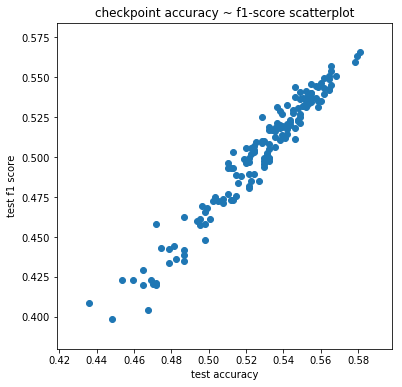

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(res_df2.test_acc, res_df2.f1_score)

ax.set_xlabel('test accuracy')
ax.set_ylabel('test f1 score')

ax.set_title('checkpoint accuracy ~ f1-score scatterplot')
plt.show()

pg_17 has three bidirectional layers with lstm dropout 0.5 and fc dropout 0.5.

In [51]:
param_grids[17]

{'BATCH_SIZE': 16,
 'EMBEDDING_DIM': 100,
 'HIDDEN_DIM': 100,
 'fc_dropout': 0.5,
 'lstm_bidirectional': True,
 'lstm_dropout': 0.5,
 'nb_1stm_layers': 3}

In [52]:
def visualise_checkpoint(pg, epoch):
    print(param_grids[pg])
    pg_df = pd.read_csv(out_dir + "/pg_{}__record.csv".format(pg))
    pg_df.set_index('epoch', inplace=True)
    best_epoch = epoch
    
    fig, ax = plt.subplots(1, 3, figsize=(16, 4))

    ax[0].plot(pg_df.training_loss)
    ax[0].plot(pg_df.val_loss)
    ax[0].vlines(best_epoch, 0.75, 1.8, color='r', linewidth=3, label='epoch={}'.format(best_epoch), alpha=0.25)
    ax[0].legend()
    ax[0].set_ylabel('loss')
    ax[0].set_xlabel('epoch')

    ax[1].plot(pg_df.training_acc)
    ax[1].plot(pg_df.val_acc)
    ax[1].vlines(best_epoch, 0.4, 0.65, color='r', linewidth=3, label='epoch={}'.format(best_epoch), alpha=0.25)
    ax[1].legend()
    ax[1].set_ylabel('accuracy')
    ax[1].set_xlabel('epoch')

    ax[2].plot(pg_df.train_f1)
    ax[2].plot(pg_df.test_f1, label='val_f1')
    ax[2].vlines(best_epoch, 0.3, 0.65, color='r', linewidth=3, label='epoch={}'.format(best_epoch), alpha=0.25)
    ax[2].legend()
    ax[2].set_ylabel('f1')
    ax[2].set_xlabel('epoch')

    fig.suptitle("pg_{} metrics over epochs".format(pg), fontsize=15)

    plt.show()

It looks like pg_17 started suffering from overfitting after 14~15 epoch going by the rising validation loss. However, pg_17 managed to deal with overfitting better than others especially when compared to other models like pg_0 that has its dropout options deactivated.

{'BATCH_SIZE': 16, 'EMBEDDING_DIM': 100, 'HIDDEN_DIM': 100, 'fc_dropout': 0.5, 'lstm_bidirectional': True, 'lstm_dropout': 0.5, 'nb_1stm_layers': 3}


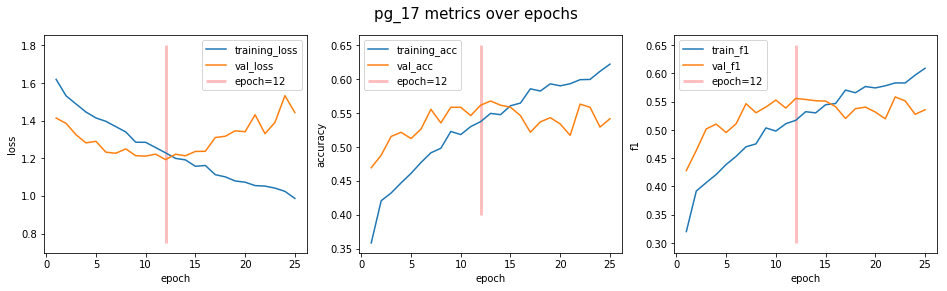

In [53]:
visualise_checkpoint(17, 12)

{'BATCH_SIZE': 16, 'EMBEDDING_DIM': 100, 'HIDDEN_DIM': 100, 'fc_dropout': 0, 'lstm_bidirectional': True, 'lstm_dropout': 0, 'nb_1stm_layers': 1}


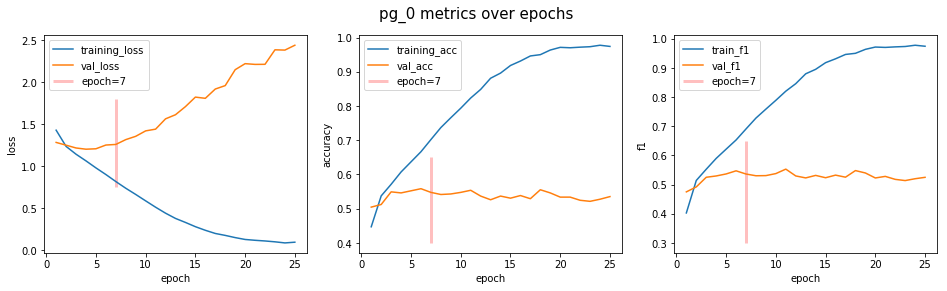

In [54]:
visualise_checkpoint(0, 7)

## Inference Test & Confusion Matrix

In [55]:
best_model_path = out_dir + '/pg_{}__epoch_{}.pth.tar'.format(17, 12)

In [56]:
best_model = load_params(LSTMModel, param_grids[17], use_gpu)
checkpoint = torch.load(best_model_path, map_location={'cuda:0': 'cpu'})
best_model.load_state_dict(checkpoint['state_dict'])

In [57]:
def inference(model, target, use_gpu):
    model.eval()
    if use_gpu:
        targetTensor = Variable(torch.Tensor([CITY.vocab.stoi[c] for c in CITY.preprocess(target)]).cuda().type(torch.LongTensor).view(len(target), -1)).cuda()
    else:
        targetTensor = Variable(torch.Tensor([CITY.vocab.stoi[c] for c in CITY.preprocess(target)]).type(torch.LongTensor).view(len(target), -1))
    model.hidden = model.init_hidden()
    model.batch_size = 1
    pred = model(targetTensor)
    res_df = pd.DataFrame([(idx, pred_val) for idx, pred_val in enumerate(pred.data.cpu().numpy()[0])], columns=['res_idx', 'nll'])
    res_df['prob'] = res_df.nll.map(lambda x: round(np.exp(x), 3))
    res_df['continent'] = res_df.res_idx.map(lambda x: CONTINENT.vocab.itos[x+1])
    res_df = res_df.sort_values(by='prob', ascending=False)
    return res_df

In [59]:
inference(best_model, 'Pyeongchang', use_gpu)

,res_idx,nll,prob,continent
0,0,-0.014178,0.986,Asia
2,2,-5.159672,0.006,Africa
4,4,-5.615287,0.004,Europe
1,1,-6.272159,0.002,North America
5,5,-6.410239,0.002,Oceania
3,3,-6.759290,0.001,South America


In [60]:
inference(best_model, 'Pyongyang', use_gpu)

,res_idx,nll,prob,continent
0,0,-0.017561,0.983,Asia
2,2,-4.879560,0.008,Africa
4,4,-5.401738,0.005,Europe
1,1,-6.174614,0.002,North America
5,5,-6.269334,0.002,Oceania
3,3,-6.627199,0.001,South America


Voila! pg_17 got the answers correct! What about some tricky England cities that sound like the ones in North America?

In [61]:
inference(best_model, 'Sheffield', use_gpu)

,res_idx,nll,prob,continent
1,1,-0.321180,0.725,North America
5,5,-2.430576,0.088,Oceania
2,2,-2.543775,0.079,Africa
4,4,-2.955052,0.052,Europe
0,0,-3.102797,0.045,Asia
3,3,-4.496040,0.011,South America


In [62]:
inference(best_model, 'Bradford', use_gpu)

,res_idx,nll,prob,continent
1,1,-0.838458,0.432,North America
4,4,-1.361331,0.256,Europe
5,5,-2.097363,0.123,Oceania
2,2,-2.284119,0.102,Africa
0,0,-3.026701,0.048,Asia
3,3,-3.265310,0.038,South America


In [63]:
inference(best_model, 'York', use_gpu)

,res_idx,nll,prob,continent
1,1,-0.825349,0.438,North America
2,2,-1.733889,0.177,Africa
5,5,-1.913949,0.147,Oceania
4,4,-2.118887,0.120,Europe
0,0,-2.342693,0.096,Asia
3,3,-3.835471,0.022,South America


As expected, the model shows suboptimal performance when given confusing questions. Let's quantify its performance by continent using sklearn's confusion matrix.

In [64]:
def evaluate_by_continent(model, data, loss_function, name):
    
    model.eval() ## eval mode
    
    avg_loss = 0.0
    truth_res = []
    pred_res = []
    
    for batch in data:
        if use_gpu:
            city, continent = batch.city_ascii.cuda(), batch.continent.cuda()
        else:
            city, continent = batch.city_ascii, batch.continent
        continent.data.sub_(1)
        truth_res += list(continent.data)
        
        model.batch_size = len(continent.data)
        model.hidden = model.init_hidden()
        
        pred = model(city)
        pred_label = pred.data.max(1)[1].cpu().numpy()
        
        pred_res += [x for x in pred_label]
        loss = loss_function(pred, continent)
        avg_loss += loss.data[0]
        
    avg_loss /= len(data)
    acc = get_accuracy(truth_res, pred_res)
    return truth_res, pred_res


In [65]:
truth_res, pred_res = evaluate_by_continent(best_model, test_iter, loss_function, 'Eval')

In [66]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from collections import Counter

In [67]:
cf = confusion_matrix(truth_res, pred_res)
cf_norm = cf.astype('float') / cf.sum(axis=1)[:, np.newaxis]

col_idx = np.arange(0, 6)
cols = [CONTINENT.vocab.itos[ci+1] for ci in col_idx]

cf_df = pd.DataFrame(cf, columns=cols, index=cols)
cf_norm_df = pd.DataFrame(cf_norm, columns=cols, index=cols)

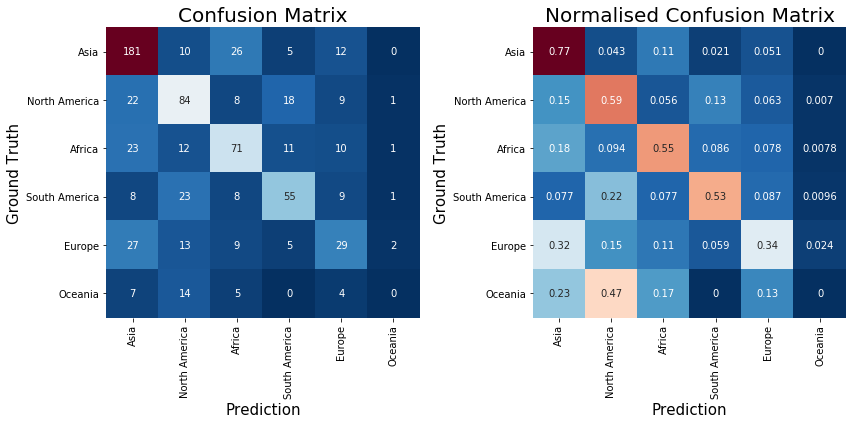

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.heatmap(cf_df, annot=True, ax=ax[0], cmap='RdBu_r', cbar=False, fmt='g')
ax[0].set_xlabel('Prediction', fontsize=15)
ax[0].set_ylabel('Ground Truth', fontsize=15)
ax[0].set_title("Confusion Matrix", fontsize=20)

sns.heatmap(cf_norm_df, annot=True, ax=ax[1], cmap='RdBu_r', cbar=False)
ax[1].set_xlabel('Prediction', fontsize=15)
ax[1].set_ylabel('Ground Truth', fontsize=15)
ax[1].set_title("Normalised Confusion Matrix", fontsize=20)
plt.tight_layout()

plt.show()

The model's prediction power is pretty good with Asian cities. It might imply that the Asian city names are named quite differently from the cities in other continents. It could be far-fetched, but I think the world history during the Great Expansion might have a plausible answer to this phenomenon. 

## Would Ensemble improve performance?
I used simple voting mechanism by which the label that is chosen the most gets to be the output of the ensemble model.

In [69]:
by_f1.head()

,pg,epoch,test_avg_loss,test_acc,f1_score,rank
0,17,12,1.189121,0.580913,0.565772,1
1,22,16,1.158638,0.579530,0.563450,2
2,22,12,1.171896,0.578147,0.559408,3
3,23,15,1.183138,0.565698,0.556997,4
4,22,15,1.170758,0.565698,0.554061,5


In [70]:
best_checkpoints = ['/output/result_dir/pg_17__epoch_12.pth.tar',
                    '/output/result_dir/pg_22__epoch_16.pth.tar',
                    '/output/result_dir/pg_22__epoch_12.pth.tar',
                    '/output/result_dir/pg_23__epoch_15.pth.tar',
                    '/output/result_dir/pg_22__epoch_15.pth.tar']

In [85]:
truth_res = None
pred_list = []
for path in best_checkpoints:
    print(path)
    pg_idx = int(re.findall('/pg_(.*)__epoch', path)[0])
    epoch = int(re.findall('__epoch_(.*).pth', path)[0])
    
    model = load_params(LSTMModel, param_grids[pg_idx], use_gpu)
    model.eval()
    checkpoint = torch.load(path, map_location={'cuda:0': 'cpu'})
    model.load_state_dict(checkpoint['state_dict'])
    truth_res, pred_res = evaluate_by_continent(model, test_iter, loss_function, 'best_models')
    truth_res = truth_res
    pred_list.append(pred_res)

/output/result_dir/pg_17__epoch_12.pth.tar
/output/result_dir/pg_22__epoch_16.pth.tar
/output/result_dir/pg_22__epoch_12.pth.tar
/output/result_dir/pg_23__epoch_15.pth.tar
/output/result_dir/pg_22__epoch_15.pth.tar


In [86]:
pred_arr = np.asarray(pred_list)

In [87]:
from scipy.stats import mode

In [88]:
ensemble_pred = mode(pred_arr, axis=0)[0][0]
truth_res = np.array(truth_res)

In [89]:
print("True label       : ", truth_res[:10])
print("Ensemble         : ", ensemble_pred[:10])
print("-------------------------------------------------")
print("pg_17__epoch_16  : ", np.array(pred_list[0][:10]))
print("pg_21__epoch_9   : ", np.array(pred_list[1][:10]))
print("pg_5__epoch_10   : ", np.array(pred_list[2][:10]))
print("pg_17__epoch_14  : ", np.array(pred_list[3][:10]))
print("pg_16__epoch_16  : ", np.array(pred_list[4][:10]))

True label       :  [4 0 3 1 2 0 2 4 0 2]
Ensemble         :  [4 0 3 2 2 3 0 2 0 2]
-------------------------------------------------
pg_17__epoch_16  :  [4 0 4 2 2 0 0 4 0 2]
pg_21__epoch_9   :  [4 0 3 2 2 3 0 2 0 0]
pg_5__epoch_10   :  [4 0 4 2 2 3 0 0 0 0]
pg_17__epoch_14  :  [4 0 2 2 2 3 0 2 0 2]
pg_16__epoch_16  :  [4 0 3 2 2 3 0 2 0 2]


In [90]:
ensemble = {'type': 'ensemble'}
single = {'type': 'single'}

In [91]:
ensemble['f1'] = round(get_f1(truth_res, ensemble_pred), 3)
ensemble['accuracy'] = round(get_accuracy(truth_res, ensemble_pred), 3)

single['f1'] = round(by_f1.iloc[0].f1_score, 3)
single['accuracy'] = round(by_accuracy.iloc[0].test_acc, 3)

In [92]:
comp = pd.DataFrame([ensemble, single])

In [93]:
print('f1-score >> ensemble: {} vs. single: {}'.format(ensemble['f1'], single['f1']))
print('accuracy >> ensemble: {} vs. single: {}'.format(ensemble['accuracy'], single['accuracy']))

f1-score >> ensemble: 0.571 vs. single: 0.566
accuracy >> ensemble: 0.589 vs. single: 0.581


In [94]:
cf = confusion_matrix(truth_res, ensemble_pred)
cf_norm = cf.astype('float') / cf.sum(axis=1)[:, np.newaxis]

col_idx = np.arange(0, 6)
cols = [CONTINENT.vocab.itos[ci+1] for ci in col_idx]

cf_df_en = pd.DataFrame(cf, columns=cols, index=cols)
cf_norm_df_en = pd.DataFrame(cf_norm, columns=cols, index=cols)

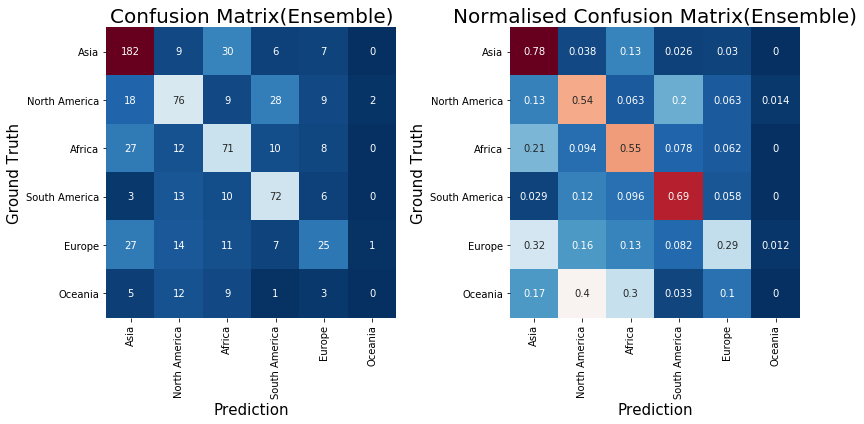

In [95]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.heatmap(cf_df_en, annot=True, ax=ax[0], cmap='RdBu_r', cbar=False, fmt='g')
ax[0].set_xlabel('Prediction', fontsize=15)
ax[0].set_ylabel('Ground Truth', fontsize=15)
ax[0].set_title("Confusion Matrix(Ensemble)", fontsize=20)

sns.heatmap(cf_norm_df_en, annot=True, ax=ax[1], cmap='RdBu_r', cbar=False)
ax[1].set_xlabel('Prediction', fontsize=15)
ax[1].set_ylabel('Ground Truth', fontsize=15)
ax[1].set_title("Normalised Confusion Matrix(Ensemble)", fontsize=20)
plt.tight_layout()

plt.show()

### Single vs. Ensemble
Let's compare the heatmaps side by side.

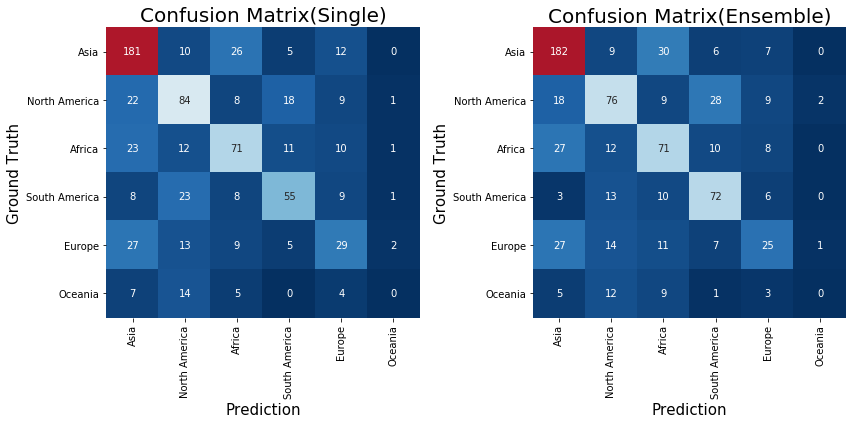

In [96]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.heatmap(cf_df, annot=True, ax=ax[0], cmap='RdBu_r', cbar=False, fmt='g', vmin=0, vmax=200)
ax[0].set_xlabel('Prediction', fontsize=15)
ax[0].set_ylabel('Ground Truth', fontsize=15)
ax[0].set_title("Confusion Matrix(Single)", fontsize=20)

sns.heatmap(cf_df_en, annot=True, ax=ax[1], cmap='RdBu_r', cbar=False, fmt='g', vmin=0, vmax=200)
ax[1].set_xlabel('Prediction', fontsize=15)
ax[1].set_ylabel('Ground Truth', fontsize=15)
ax[1].set_title("Confusion Matrix(Ensemble)", fontsize=20)
plt.tight_layout()

plt.show()

### Single vs. Ensemble (Normalised)
The Ensemble model is better at Asian and North American cities, but not at African, European, and Oceanian cities.

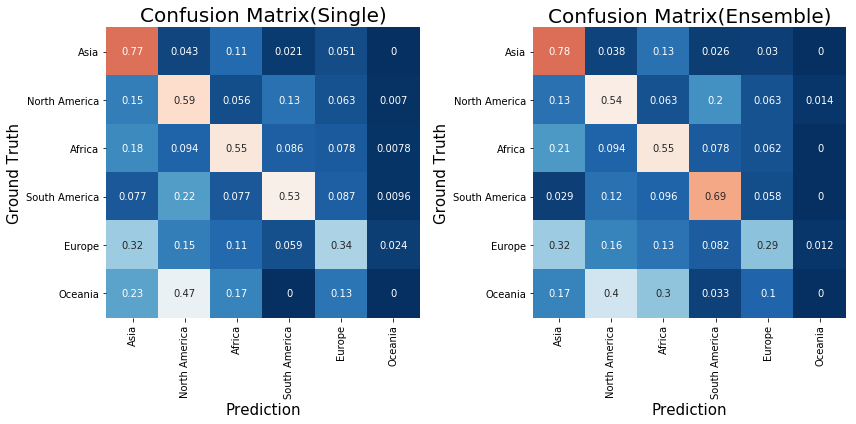

In [97]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.heatmap(cf_norm_df, annot=True, ax=ax[0], cmap='RdBu_r', cbar=False, vmin=0, vmax=1)
ax[0].set_xlabel('Prediction', fontsize=15)
ax[0].set_ylabel('Ground Truth', fontsize=15)
ax[0].set_title("Confusion Matrix(Single)", fontsize=20)

sns.heatmap(cf_norm_df_en, annot=True, ax=ax[1], cmap='RdBu_r', cbar=False, vmin=0, vmax=1)
ax[1].set_xlabel('Prediction', fontsize=15)
ax[1].set_ylabel('Ground Truth', fontsize=15)
ax[1].set_title("Confusion Matrix(Ensemble)", fontsize=20)
plt.tight_layout()

plt.show()

### Inference with Ensemble model
I used the simple voting rule for choosing the prediction label.

In [98]:
models = []
for path in best_checkpoints:
    print(path)
    pg_idx = int(re.findall('/pg_(.*)__epoch', path)[0])
    epoch = int(re.findall('__epoch_(.*).pth', path)[0])
    
    model = load_params(LSTMModel, param_grids[pg_idx], use_gpu)
    model.eval()
    checkpoint = torch.load(path, map_location={'cuda:0': 'cpu'})
    model.load_state_dict(checkpoint['state_dict'])
    models.append(model)

/output/result_dir/pg_17__epoch_12.pth.tar
/output/result_dir/pg_22__epoch_16.pth.tar
/output/result_dir/pg_22__epoch_12.pth.tar
/output/result_dir/pg_23__epoch_15.pth.tar
/output/result_dir/pg_22__epoch_15.pth.tar


In [110]:
def ensemble_inference(models, target, use_gpu):
    if use_gpu:
        targetTensor = Variable(torch.Tensor([CITY.vocab.stoi[c] for c in CITY.preprocess(target)]).cuda().type(torch.LongTensor).view(len(target), -1)).cuda()
    else:
        targetTensor = Variable(torch.Tensor([CITY.vocab.stoi[c] for c in CITY.preprocess(target)]).type(torch.LongTensor).view(len(target), -1))
    
    pred_idx_list = []
    for cmodel in models:
        cmodel.eval()
        cmodel.hidden = cmodel.init_hidden()
        cmodel.batch_size = 1
        pred = cmodel(targetTensor)
        pred_idx = np.argmax(pred.data.cpu().numpy()[0])
        pred_idx_list.append(pred_idx)
        
        time.sleep(0.1)
                
    (res, cnt) = Counter(pred_idx_list).most_common(1)[0]
    prediction = CONTINENT.vocab.itos[res + 1]
    return cnt, target, prediction  


In [111]:
cnt, target, prediction = ensemble_inference(models, 'Sheffield', use_gpu)
print("{} models predicted {} to be in {}.".format(cnt, target, prediction))

5 models predicted Sheffield to be in North America.


In [112]:
ensemble_inference(models, 'Bratford', use_gpu)
print("{} models predicted {} to be in {}.".format(cnt, target, prediction))

5 models predicted Sheffield to be in North America.


In [113]:
ensemble_inference(models, 'York', use_gpu)
print("{} models predicted {} to be in {}.".format(cnt, target, prediction))

5 models predicted Sheffield to be in North America.


It turned out that they are all incorrect given cities in the UK. Perhaps mixing models that are strong in each continent categories would produce better results.

## 6. GAME!

So now I have a deep learning algorithm that predicts its continent given a name of a city. It would be of great fun to play a game against this AI!! Sounds super nerdy. The function `run_test_single` and `run_test_ensemble` randomly choose a record from the test dataset and return a machine-predicted label.

In [114]:
test_set = pd.read_csv('dataset/_test.csv')

In [116]:
def judge(m_pred, gt):
    if m_pred == gt:
        return "Correct!"
    else:
        return "Incorrect!"

def run_test_single():
    sample = test_set.sample()
    city = sample.city_ascii.values[0]
    continent = sample.continent.values[0]
    print("Which Continent does **{}** belong to?".format(city))
    print(">>> Correct Answer: {}".format(continent))
    print("-----------------------------------------------")
    res_df = inference(best_model, city, use_gpu).sort_values(by='prob', ascending=False)
    m_pred = res_df.iloc[0].continent
    m_pred_prob = res_df.iloc[0].prob
    
    print("Machine prediction: {}({}) -- {}".format(m_pred, m_pred_prob, judge(m_pred, continent)))
    
run_test_single()

Which Continent does **Jining** belong to?
>>> Correct Answer: Asia
-----------------------------------------------
Machine prediction: Asia(0.948) -- Correct!


In [117]:
def run_test_ensemble():
    sample = test_set.sample()
    city = sample.city_ascii.values[0]
    continent = sample.continent.values[0]
    print("Which Continent does **{}** belong to?".format(city))
    print(">>> Correct Answer: {}".format(continent))
    print("-----------------------------------------------")
    cnt, target, prediction = ensemble_inference(models, city, use_gpu)
    
    print("{} Machine prediction: {} -- {}".format(cnt, prediction, judge(prediction, continent)))
    
run_test_ensemble()

Which Continent does **Demba** belong to?
>>> Correct Answer: Africa
-----------------------------------------------
5 Machine prediction: Africa -- Correct!


Making a web game with AWS Lambda or EC2 would be more than great, but it's too much for me to build everything on my own. To see how fun it is to play this game, I ran the above function 10 times and see if my parents-in-laws, my wife and myself could beat the model!

The results are..

** Human vs. AI **  
Parents 4 vs 6 AI  
Wife    4 vs 6 AI  
Me      2 vs 5 AI  

Here's my score table. I mean.. where the hell is Tom Price? Tom Price is a city in Western Austrailia.

|    | Question              | Me | AI |
|----|-----------------------|----|----|
| 1  | Haeju                 | 1  | 1  |
| 2  | Fond Du Lac           | 0  | 1  |
| 3  | San Juan De Nicaragua | 0  | 0  |
| 4  | Altata                | 0  | 0  |
| 5  | Porvoo                | 1  | 1  |
| 6  | Almirante             | 0  | 1  |
| 7  | Cap-Haitien           | 0  | 1  |
| 8  | Raleigh               | 0  | 0  |
| 9  | Atqasuk               | 0  | 0  |
| 10 | Tom Price             | 0  | 0  |
|    | Total Score           | 2  | 5  |